# Bayesian Models

1. Bayesian Neural Network
2. Monte Carlo Dropout
3. Deep Ensemble

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

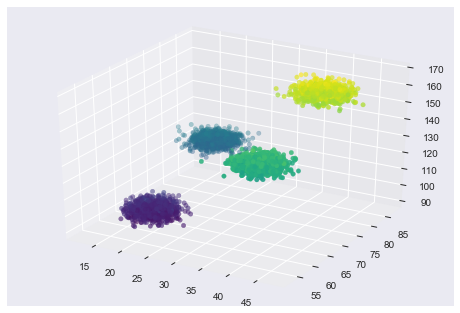

In [2]:
from data.synthetic import get_normal_data, plot_data

X, y = get_normal_data(1000)
plot_data(X, y)

# Variational Bayes

Bayesian Neural Network using Variational Inference

Ref:
* Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches: https://arxiv.org/abs/1803.04386
* https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf
* https://github.com/krasserm/bayesian-machine-learning/blob/master/bayesian_neural_networks.ipynb
* https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py

In [3]:
class BayesNN:
    """Bayesian neural network using Flipout estimator"""
    def __init__(self, x_features, y_features, n_hidden=32, n_layers=3):
        self.x_features = x_features
        self.y_features = y_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss = lambda y, distr: -distr.log_prob(y)
        self.normal_sp = lambda params: tfd.Normal(
            loc=params[:,0:1],
            scale=1e-3+tf.math.softplus(0.05*params[:,1:2]))
        self.bias_posterior_fn = tfp.layers.util.default_mean_field_normal_fn()
        self.bias_prior_fn = tfp.layers.default_multivariate_normal_fn
        
    def kernel_divergence_fn(self, n_samples):
        return lambda q, p, _: tfp.distributions.kl_divergence(q, p) / n_samples
    
    def bias_divergence_fn(self, n_samples):
        return lambda q, p, _: tfp.distributions.kl_divergence(q, p) / n_samples
        
    def build_model(self, n_samples):
        self.model = tf.keras.Sequential([])
        for _ in range(self.n_layers):
            self.model.add(
                tfp.layers.DenseFlipout(self.n_hidden,
                    bias_posterior_fn=self.bias_posterior_fn,
                    bias_prior_fn=self.bias_prior_fn,
                    kernel_divergence_fn=self.kernel_divergence_fn(n_samples),
                    bias_divergence_fn=self.bias_divergence_fn(n_samples),
                    activation="relu"))
        self.model.add(tfp.layers.DistributionLambda(self.normal_sp))
        self.model.compile(self.optimizer, self.loss)
    
    def fit(self, X, y, epochs=1000, batch_size=32, verbose=1):
        self.build_model(n_samples=X.shape[0])
        return self.model.fit(X, y,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=verbose)
    
    def sample(self, X):
        return self.model.predict(X)

In [4]:
bnn = BayesNN(x_features=2, y_features=1, n_hidden=32, n_layers=3)
bnn.fit(X, y, epochs=1000)

Epoch 1/1000
Instructions for updating:
Please use `layer.add_weight` method instead.
125/125 [==============================] - ETA: 0s - loss: 6229.63 - 0s 2ms/step - loss: 5427.9712
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 81.0241
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 11.4977
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 10.0711
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.3708
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7715
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3160
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.0281
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1948
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1745
Epoch 11/1000
125/125 [==============================] - 0s 1ms/

125/125 [==============================] - 0s 1ms/step - loss: 3.6904
Epoch 94/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6864
Epoch 95/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6577
Epoch 96/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6725
Epoch 97/1000
125/125 [==============================] - 0s 2ms/step - loss: 3.6458
Epoch 98/1000
125/125 [==============================] - 0s 2ms/step - loss: 3.6580
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6385
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6273
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6117
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6107
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6080
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5995
E

125/125 [==============================] - 0s 1ms/step - loss: 3.1319
Epoch 189/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1270
Epoch 190/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1273
Epoch 191/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1304
Epoch 192/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1230
Epoch 193/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1199
Epoch 194/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1263
Epoch 195/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1225
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1181
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1111
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1247
Epoch 199/1000
125/125 [==============================] - ETA: 0s - loss: 3.117 

125/125 [==============================] - 0s 1ms/step - loss: 2.9689
Epoch 284/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9756
Epoch 285/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9666
Epoch 286/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9746
Epoch 287/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9744
Epoch 288/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9640
Epoch 289/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9616
Epoch 290/1000
125/125 [==============================] - ETA: 0s - loss: 2.952 - ETA: 0s - loss: 2.962 - 0s 1ms/step - loss: 2.9643
Epoch 291/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9716
Epoch 292/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9606
Epoch 293/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9524
Epoch 294/1000
125/125 [========

125/125 [==============================] - 0s 1ms/step - loss: 2.8805
Epoch 379/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8721
Epoch 380/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8717
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8795
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8680
Epoch 383/1000
125/125 [==============================] - ETA: 0s - loss: 2.876 - 0s 1ms/step - loss: 2.8811
Epoch 384/1000
125/125 [==============================] - ETA: 0s - loss: 2.891 - 0s 1ms/step - loss: 2.8828
Epoch 385/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8710
Epoch 386/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8766
Epoch 387/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8787
Epoch 388/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8942
Epoch 389/1000
125/125 [========

125/125 [==============================] - 0s 1ms/step - loss: 2.8631
Epoch 474/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.8543
Epoch 475/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.8565
Epoch 476/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8434
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8590
Epoch 478/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8442
Epoch 479/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8652
Epoch 480/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8553
Epoch 481/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.8645
Epoch 482/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.8545
Epoch 483/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8652
Epoch 484/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 2.8518
Epoch 568/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8328
Epoch 569/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8368
Epoch 570/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8371
Epoch 571/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8305
Epoch 572/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8521
Epoch 573/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8326
Epoch 574/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8453
Epoch 575/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8297
Epoch 576/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8319
Epoch 577/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8396
Epoch 578/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 2.8289
Epoch 662/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8196
Epoch 663/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8179
Epoch 664/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8159
Epoch 665/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8178
Epoch 666/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8190
Epoch 667/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8139
Epoch 668/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8199
Epoch 669/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8115
Epoch 670/1000
125/125 [==============================] - ETA: 0s - loss: 2.828 - 0s 1ms/step - loss: 2.8275
Epoch 671/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8310
Epoch 672/1000
125/125 [==============================] 

125/125 [==============================] - 0s 1ms/step - loss: 2.8064
Epoch 757/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8580
Epoch 758/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7894
Epoch 759/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.8010
Epoch 760/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7994
Epoch 761/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7936
Epoch 762/1000
125/125 [==============================] - 0s 2ms/step - loss: 2.7940
Epoch 763/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7985
Epoch 764/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7862
Epoch 765/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7982
Epoch 766/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8098
Epoch 767/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 2.7714
Epoch 852/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7660
Epoch 853/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7714
Epoch 854/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7787
Epoch 855/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7742
Epoch 856/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7648
Epoch 857/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7857
Epoch 858/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7973
Epoch 859/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7705
Epoch 860/1000
125/125 [==============================] - ETA: 0s - loss: 2.766 - 0s 1ms/step - loss: 2.7661
Epoch 861/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7735
Epoch 862/1000
125/125 [==============================] 

125/125 [==============================] - 0s 1ms/step - loss: 2.7484
Epoch 946/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7533
Epoch 947/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7620
Epoch 948/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7467
Epoch 949/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7514
Epoch 950/1000
125/125 [==============================] - ETA: 0s - loss: 2.747 - 0s 1ms/step - loss: 2.7425
Epoch 951/1000
125/125 [==============================] - ETA: 0s - loss: 2.740 - 0s 1ms/step - loss: 2.7526
Epoch 952/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7433
Epoch 953/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7729
Epoch 954/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7402
Epoch 955/1000
125/125 [==============================] - ETA: 0s - loss: 2.752 - 0s 1ms/step - loss: 2.7485
Epoch 95

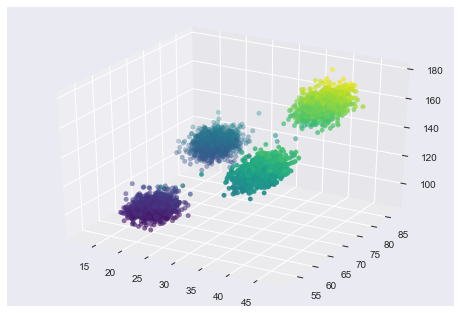

In [5]:
y_hat = bnn.sample(X)
plot_data(X, y_hat)

In [6]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.15500485725777294
rKL: 0.21514344062096513
JS: 0.038335629924665535


# Monte Carlo Dropout

Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning: https://arxiv.org/abs/1506.02142

Dropout is commonly used to prevent deep learning models from overfitting, by randomly zeroing-out activations during training and scale activations by p during testing. Dropout with some modifications is useful for estimating uncertainty of the model during prediction. Monte Carlo Dropout combines predictions of multiple forward passes of the same data point X through the network while applying different dropout masks. MC Dropout applies dropout both during training and testing.

1. Train a neural network f_θ(x) containing Dropout layers and an appropriate probabilistic loss.
2. During testing, perform T stochastic forward passes through f_θ(x) to obtain predictions for input x.
3. Combine predictions to obtain an expectation-based prediction and uncertainty estimate.

Ref:
* https://everyhue.me/posts/why-uncertainty-matters/
* https://github.com/huyng/incertae/blob/master/mcdrop_regression.ipynb

In [7]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential


class MCDropout:
    def __init__(self, x_features, y_features, n_hidden=32, dropout=0.5):
        self.x_features = x_features
        self.y_features = y_features
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.model = self.build_model()
    
    def build_model(self):
        model = Sequential([
            Dense(self.n_hidden, activation='relu'),
            Dense(self.n_hidden, activation='tanh'),
            Dropout(self.dropout),
            Dense(self.y_features + 1, activation=None),
        ])
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss=self.loss, optimizer=optimizer)
        return model
    
    def loss(self, y_true, y_pred):
        """Gaussian negative log likelihood.
            -log p(y|x) = log(sigma^2)/2 + (y-mu)^2/2sigma^2
        Model predits log(sigma^2) rather than sigma^2 for stability."""
        mu = y_pred[:, :-1]
        sigma = y_pred[:, -1:]
        loss = (sigma + tf.square(y_true - mu)/tf.math.exp(sigma)) / 2.0
        return tf.reduce_mean(loss)
    
    def fit(self, X, y, epochs=1000, verbose=1):
        self.model.fit(X, y, batch_size=32, epochs=epochs, verbose=verbose)
        
    def predict(self, X, T=20):
        """Perform T stochastic forward passes."""
        mus, sigmas = [], []
        for t in range(T):
            print(f"Performing forward pass {t+1}/{T}")
            y_hat = self.model(X, training=True)
            mu, sigma = y_hat[:,:-1], y_hat[:,-1:]
            mus.append(mu)
            sigmas.append(sigma)
        
        mus = np.array(mus)
        sigmas = np.array(sigmas)
        variances = np.exp(sigmas)
        
        y_mean = np.mean(mus, axis=0)
        y_std = np.sqrt(np.mean(variances + mus**2, axis=0) - y_mean**2)
        return y_mean, y_std

In [8]:
mcdropout = MCDropout(X.shape[1], y.shape[1], n_hidden=32, dropout=0.3)
mcdropout.fit(X, y, epochs=1000)

Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 5749.1450
Epoch 2/1000
125/125 [==============================] - 0s 992us/step - loss: 276.1268
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 246.7486
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 216.1109
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 203.1778
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 176.5419
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 163.5018
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 142.6008
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 124.4355
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 109.4041
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 104.9911
Epoch 12/1000
125/125 [==============================] - 0s 

Epoch 96/1000
125/125 [==============================] - 0s 985us/step - loss: 5.9288
Epoch 97/1000
125/125 [==============================] - 0s 982us/step - loss: 5.9570
Epoch 98/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9205
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9323A: 0s - loss: 5.938
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8938
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9489
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9255
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8847
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9103
Epoch 105/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9153
Epoch 106/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9392
Epoch 107/1000
125/125 [======================

125/125 [==============================] - 0s 1ms/step - loss: 3.5867
Epoch 189/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5682
Epoch 190/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5572
Epoch 191/1000
125/125 [==============================] - 0s 992us/step - loss: 3.5561 0s - loss: 3.546
Epoch 192/1000
125/125 [==============================] - 0s 977us/step - loss: 3.5239
Epoch 193/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5674
Epoch 194/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5256
Epoch 195/1000
125/125 [==============================] - 0s 980us/step - loss: 3.5556
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5294
Epoch 197/1000
125/125 [==============================] - 0s 981us/step - loss: 3.5530
Epoch 198/1000
125/125 [==============================] - 0s 973us/step - loss: 3.5797
Epoch 199/1000
125/125 [=============================

125/125 [==============================] - 0s 1000us/step - loss: 3.2668
Epoch 283/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2571
Epoch 284/1000
125/125 [==============================] - 0s 988us/step - loss: 3.2586
Epoch 285/1000
125/125 [==============================] - 0s 986us/step - loss: 3.2868
Epoch 286/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2428
Epoch 287/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2575
Epoch 288/1000
125/125 [==============================] - 0s 980us/step - loss: 3.2285 0s - loss: 3.228
Epoch 289/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2714
Epoch 290/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2420
Epoch 291/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2515
Epoch 292/1000
125/125 [==============================] - 0s 992us/step - loss: 3.2722
Epoch 293/1000
125/125 [============================

125/125 [==============================] - 0s 1ms/step - loss: 3.1729
Epoch 375/1000
125/125 [==============================] - 0s 981us/step - loss: 3.1566
Epoch 376/1000
125/125 [==============================] - 0s 996us/step - loss: 3.1460
Epoch 377/1000
125/125 [==============================] - 0s 983us/step - loss: 3.1512
Epoch 378/1000
125/125 [==============================] - 0s 986us/step - loss: 3.1429
Epoch 379/1000
125/125 [==============================] - 0s 974us/step - loss: 3.1492
Epoch 380/1000
125/125 [==============================] - 0s 999us/step - loss: 3.1252
Epoch 381/1000
125/125 [==============================] - 0s 984us/step - loss: 3.1574
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1264
Epoch 383/1000
125/125 [==============================] - 0s 987us/step - loss: 3.1568
Epoch 384/1000
125/125 [==============================] - 0s 967us/step - loss: 3.1464
Epoch 385/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 982us/step - loss: 3.0937
Epoch 468/1000
125/125 [==============================] - 0s 983us/step - loss: 3.0905
Epoch 469/1000
125/125 [==============================] - 0s 992us/step - loss: 3.0830
Epoch 470/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0974
Epoch 471/1000
125/125 [==============================] - 0s 980us/step - loss: 3.1078
Epoch 472/1000
125/125 [==============================] - 0s 969us/step - loss: 3.0804
Epoch 473/1000
125/125 [==============================] - 0s 983us/step - loss: 3.0924
Epoch 474/1000
125/125 [==============================] - 0s 968us/step - loss: 3.0732
Epoch 475/1000
125/125 [==============================] - 0s 984us/step - loss: 3.0891
Epoch 476/1000
125/125 [==============================] - 0s 982us/step - loss: 3.0957
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1015
Epoch 478/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 3.0407
Epoch 560/1000
125/125 [==============================] - 0s 976us/step - loss: 3.0557
Epoch 561/1000
125/125 [==============================] - ETA: 0s - loss: 3.063 - 0s 969us/step - loss: 3.0546
Epoch 562/1000
125/125 [==============================] - ETA: 0s - loss: 3.047 - 0s 999us/step - loss: 3.0556
Epoch 563/1000
125/125 [==============================] - 0s 972us/step - loss: 3.0362
Epoch 564/1000
125/125 [==============================] - 0s 987us/step - loss: 3.0590
Epoch 565/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0475
Epoch 566/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0535
Epoch 567/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0604
Epoch 568/1000
125/125 [==============================] - 0s 993us/step - loss: 3.0437 0s - loss: 3.040
Epoch 569/1000
125/125 [==============================] - 0s 973us/step - loss: 3.0384 0

125/125 [==============================] - 0s 1ms/step - loss: 2.9963
Epoch 653/1000
125/125 [==============================] - 0s 990us/step - loss: 2.9889
Epoch 654/1000
125/125 [==============================] - 0s 976us/step - loss: 2.9842
Epoch 655/1000
125/125 [==============================] - ETA: 0s - loss: 3.0249- ETA: 0s - loss: 3.04 - 0s 983us/step - loss: 3.0223
Epoch 656/1000
125/125 [==============================] - 0s 968us/step - loss: 3.0001
Epoch 657/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0125
Epoch 658/1000
125/125 [==============================] - 0s 981us/step - loss: 2.9898
Epoch 659/1000
125/125 [==============================] - 0s 970us/step - loss: 2.9853
Epoch 660/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9785
Epoch 661/1000
125/125 [==============================] - 0s 975us/step - loss: 2.9850
Epoch 662/1000
125/125 [==============================] - 0s 960us/step - loss: 2.9843
Epoch 663/1000
12

125/125 [==============================] - ETA: 0s - loss: 2.938 - 0s 1ms/step - loss: 2.9384
Epoch 745/1000
125/125 [==============================] - 0s 998us/step - loss: 2.9534
Epoch 746/1000
125/125 [==============================] - 0s 971us/step - loss: 2.9417
Epoch 747/1000
125/125 [==============================] - 0s 974us/step - loss: 2.9313
Epoch 748/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9474A: 0s - loss: 2.92
Epoch 749/1000
125/125 [==============================] - ETA: 0s - loss: 2.962 - 0s 976us/step - loss: 2.9649
Epoch 750/1000
125/125 [==============================] - 0s 992us/step - loss: 2.9446
Epoch 751/1000
125/125 [==============================] - 0s 970us/step - loss: 2.9455
Epoch 752/1000
125/125 [==============================] - 0s 998us/step - loss: 2.9228
Epoch 753/1000
125/125 [==============================] - 0s 972us/step - loss: 2.9362
Epoch 754/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.939

125/125 [==============================] - 0s 985us/step - loss: 2.9036
Epoch 838/1000
125/125 [==============================] - 0s 991us/step - loss: 2.9033
Epoch 839/1000
125/125 [==============================] - 0s 980us/step - loss: 2.9054
Epoch 840/1000
125/125 [==============================] - 0s 988us/step - loss: 2.8930
Epoch 841/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8897
Epoch 842/1000
125/125 [==============================] - 0s 964us/step - loss: 2.8743
Epoch 843/1000
125/125 [==============================] - ETA: 0s - loss: 2.880 - 0s 984us/step - loss: 2.8849
Epoch 844/1000
125/125 [==============================] - 0s 968us/step - loss: 2.8828
Epoch 845/1000
125/125 [==============================] - 0s 979us/step - loss: 2.8814
Epoch 846/1000
125/125 [==============================] - 0s 991us/step - loss: 2.8989
Epoch 847/1000
125/125 [==============================] - 0s 985us/step - loss: 2.8976
Epoch 848/1000
125/125 [============

125/125 [==============================] - 0s 1ms/step - loss: 2.8713
Epoch 930/1000
125/125 [==============================] - 0s 986us/step - loss: 2.8173
Epoch 931/1000
125/125 [==============================] - 0s 986us/step - loss: 2.8176
Epoch 932/1000
125/125 [==============================] - 0s 987us/step - loss: 2.8240
Epoch 933/1000
125/125 [==============================] - 0s 991us/step - loss: 2.8279
Epoch 934/1000
125/125 [==============================] - 0s 979us/step - loss: 2.8303
Epoch 935/1000
125/125 [==============================] - 0s 972us/step - loss: 2.8478
Epoch 936/1000
125/125 [==============================] - 0s 988us/step - loss: 2.8536
Epoch 937/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8502
Epoch 938/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8263
Epoch 939/1000
125/125 [==============================] - 0s 999us/step - loss: 2.8306
Epoch 940/1000
125/125 [==============================] - 0s 976

Performing forward pass 1/5
Performing forward pass 2/5
Performing forward pass 3/5
Performing forward pass 4/5
Performing forward pass 5/5


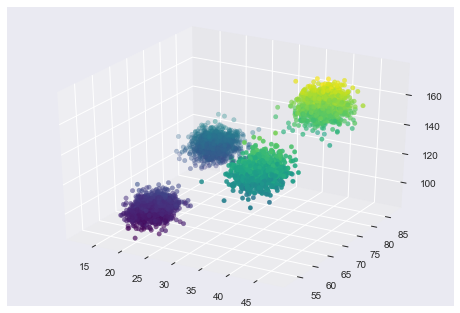

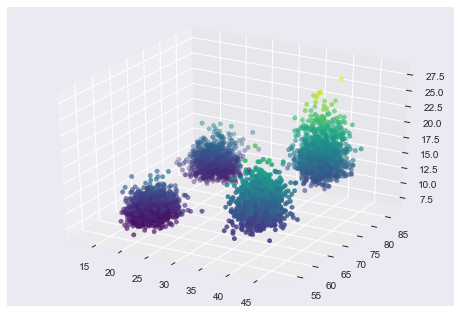

In [18]:
y_mean, y_std = mcdropout.predict(X, T=5)
plot_data(X, y_mean)
plot_data(X, y_std)

In [19]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_mean, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.24977160502588575
rKL: 0.41342784936752397
JS: 0.06587182203216804


# Deep Ensemble

Deep Ensembles use M trained models initialised from random starting points to collect Monte Carlo samples.

Ref:
* https://github.com/huyng/incertae/blob/master/ensemble_regression.ipynb
* Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles: https://arxiv.org/abs/1612.01474
* Deep Ensembles: A Loss Landscape Perspective: https://arxiv.org/pdf/1912.02757.pdf

In [11]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential


class DeepEnsemble:
    def __init__(self, x_features, y_features, n_models=5, n_hidden=20, dropout=0.5):
        self.x_features = x_features
        self.y_features = y_features
        self.n_models = n_models
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.models = [self.build_model() for _ in range(n_models)]
    
    def build_model(self):
        model = Sequential([
            Dense(self.n_hidden, activation='relu'),
            Dense(self.n_hidden, activation='tanh'),
            Dropout(self.dropout),
            Dense(self.y_features + 1, activation=None),
        ])
        optimizer = tf.keras.optimizers.Adam(0.001)
        model.compile(loss=self.loss, optimizer=optimizer)
        return model
    
    def loss(self, y_true, y_pred):
        """Gaussian negative log likelihood.
            -log p(y|x) = log(sigma^2)/2 + (y-mu)^2/2sigma^2
        Model predits log(sigma^2) rather than sigma^2 for stability."""
        mu = y_pred[:, :-1]
        sigma = y_pred[:, -1:]
        loss = (sigma + tf.square(y_true - mu)/tf.math.exp(sigma)) / 2.0
        return tf.reduce_mean(loss)
    
    def fit(self, X, y, epochs=100, verbose=1):  # TODO: Fit subset of data per model
        for i in range(len(self.models)):
            print(f"Training model {i+1}/{len(self.models)}")
            self.models[i].fit(X, y, batch_size=32, epochs=epochs, verbose=verbose)
        
    def predict(self, X):
        """Perform T stochastic forward passes."""
        mus, sigmas = [], []
        for t, model in enumerate(self.models):
            print(f"Performing forward pass {t+1}/{len(self.models)}")
            y_hat = model(X)
            mu, sigma = y_hat[:,:-1], y_hat[:,-1:]
            mus.append(mu)
            sigmas.append(sigma)  # TODO: check merging ensemble results for variance
            
        mus = np.array(mus)
        sigmas = np.array(sigmas)
        variances = np.exp(sigmas)
        
        y_mean = np.mean(mus, axis=0)
        y_variance = np.mean(variances + mus**2, axis=0) - y_mean**2
        y_std = np.sqrt(y_variance)
        return y_mean, y_std

In [12]:
deepensem = DeepEnsemble(X.shape[1], y.shape[1], n_models=5, n_hidden=32, dropout=0.3)
deepensem.fit(X, y, epochs=1000)

Training model 1/5
Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 218.1305
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 17.9948
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 16.1081
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 13.7211
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 12.3037
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 11.3630
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 10.1975
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.4824TA: 0s - loss: 9.657
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.9248
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3914
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.0402
Epoch 12/1000
125/125 [===============

125/125 [==============================] - 0s 1ms/step - loss: 4.7291
Epoch 96/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7056
Epoch 97/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.5787
Epoch 98/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.4866
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.4026
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.3046
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.2415
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.1390
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.0385
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.9742
Epoch 105/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.9594A: 0s - loss: 3.961
Epoch 106/1000
125/125 [==============================] - 0s 1ms/

125/125 [==============================] - 0s 1ms/step - loss: 3.3722A: 0s - loss: 3.384
Epoch 189/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3521
Epoch 190/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3818
Epoch 191/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3653
Epoch 192/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3649
Epoch 193/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3631A: 0s - loss: 3.377
Epoch 194/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3529
Epoch 195/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3426
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3671
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3452
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3599
Epoch 199/1000
125/125 [==================

125/125 [==============================] - 0s 1ms/step - loss: 3.2030
Epoch 283/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1794
Epoch 284/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1730
Epoch 285/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1839
Epoch 286/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1721
Epoch 287/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1723
Epoch 288/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1777A: 0s - loss: 3.16
Epoch 289/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1721A: 0s - loss: 3.175
Epoch 290/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1682
Epoch 291/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1549
Epoch 292/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1742A: 0s - loss: 3.170
Epoch 293/1000
125/125 [

125/125 [==============================] - 0s 1ms/step - loss: 3.1242
Epoch 376/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1086
Epoch 377/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1048
Epoch 378/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0965
Epoch 379/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1203
Epoch 380/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1109
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1118
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0942A: 0s - loss: 3.095
Epoch 383/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1192
Epoch 384/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0917A: 0s - loss: 3.096
Epoch 385/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1017
Epoch 386/1000
125/125 [==================

125/125 [==============================] - 0s 1ms/step - loss: 3.0367
Epoch 470/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0353
Epoch 471/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0537
Epoch 472/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0424
Epoch 473/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0422
Epoch 474/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0499
Epoch 475/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0328
Epoch 476/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0497
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0497
Epoch 478/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0403A: 0s - loss: 3.01
Epoch 479/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0307
Epoch 480/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 3.0098
Epoch 564/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9938A: 0s - loss: 3.00
Epoch 565/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0054
Epoch 566/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0193
Epoch 567/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9992
Epoch 568/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9826
Epoch 569/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0115
Epoch 570/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0115
Epoch 571/1000
125/125 [==============================] - ETA: 0s - loss: 2.998 - 0s 1ms/step - loss: 2.9983
Epoch 572/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9951
Epoch 573/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9946A: 0s - loss: 3.00
Epoch 574/1000
125/1

125/125 [==============================] - 0s 1ms/step - loss: 2.9487
Epoch 655/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9454
Epoch 656/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9583
Epoch 657/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9408
Epoch 658/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9507A: 0s - loss: 2.95
Epoch 659/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9381
Epoch 660/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9319
Epoch 661/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9595A: 0s - loss: 2.963
Epoch 662/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9315
Epoch 663/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9432
Epoch 664/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9298
Epoch 665/1000
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 2.8984A: 0s - loss: 2.892
Epoch 748/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8828
Epoch 749/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8970
Epoch 750/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8893
Epoch 751/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8964
Epoch 752/1000
125/125 [==============================] - ETA: 0s - loss: 2.906 - 0s 1ms/step - loss: 2.9028
Epoch 753/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8923
Epoch 754/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9027
Epoch 755/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8845
Epoch 756/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8887
Epoch 757/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8851
Epoch 758/1000
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 2.8623
Epoch 841/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8475
Epoch 842/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8481
Epoch 843/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8632
Epoch 844/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8230
Epoch 845/1000
125/125 [==============================] - ETA: 0s - loss: 2.839 - 0s 1ms/step - loss: 2.8410
Epoch 846/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8372
Epoch 847/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8166
Epoch 848/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8450
Epoch 849/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8273
Epoch 850/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8378A: 0s - loss: 2.82
Epoch 851/1000
125/125 [==============

125/125 [==============================] - 0s 1ms/step - loss: 2.7901
Epoch 933/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7828
Epoch 934/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7640
Epoch 935/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7800
Epoch 936/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7725
Epoch 937/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7883
Epoch 938/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7911
Epoch 939/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7820
Epoch 940/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7782
Epoch 941/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7701
Epoch 942/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7676
Epoch 943/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 6.4803
Epoch 26/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3549
Epoch 27/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.2543
Epoch 28/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.2304
Epoch 29/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.2190
Epoch 30/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1453
Epoch 31/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1342
Epoch 32/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0996
Epoch 33/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0452
Epoch 34/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0426
Epoch 35/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0301
Epoch 36/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9675A: 0s -

125/125 [==============================] - 0s 1ms/step - loss: 3.8603
Epoch 121/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.8006
Epoch 122/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.8165
Epoch 123/1000
125/125 [==============================] - 0s 997us/step - loss: 3.8157
Epoch 124/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.8038A: 0s - loss: 3.814
Epoch 125/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7700
Epoch 126/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.8012
Epoch 127/1000
125/125 [==============================] - 0s 999us/step - loss: 3.8099
Epoch 128/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.8022
Epoch 129/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7937
Epoch 130/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7730
Epoch 131/1000
125/125 [==============================] -

Epoch 211/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6106
Epoch 212/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5758
Epoch 213/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5716
Epoch 214/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6113
Epoch 215/1000
125/125 [==============================] - ETA: 0s - loss: 3.612 - 0s 1ms/step - loss: 3.6050
Epoch 216/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5724A: 0s - loss: 3.580
Epoch 217/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6038
Epoch 218/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5946
Epoch 219/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5711
Epoch 220/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5829
Epoch 221/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5669
Epoch 222/1000
125/125

125/125 [==============================] - 0s 1ms/step - loss: 3.5370
Epoch 305/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5504
Epoch 306/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5277
Epoch 307/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5423
Epoch 308/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5238A: 0s - loss: 3.5
Epoch 309/1000
125/125 [==============================] - ETA: 0s - loss: 3.538 - 0s 1ms/step - loss: 3.5377
Epoch 310/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5407
Epoch 311/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5420
Epoch 312/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5311
Epoch 313/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5382
Epoch 314/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5237
Epoch 315/1000
125/125 [===============

125/125 [==============================] - 0s 1ms/step - loss: 3.3550
Epoch 399/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3428
Epoch 400/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3336
Epoch 401/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3489
Epoch 402/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3350
Epoch 403/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3478
Epoch 404/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3405
Epoch 405/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3332
Epoch 406/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3317
Epoch 407/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3491
Epoch 408/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.3272
Epoch 409/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.

125/125 [==============================] - 0s 1ms/step - loss: 3.1467
Epoch 495/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1792
Epoch 496/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1760A: 0s - loss: 3.17
Epoch 497/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1767
Epoch 498/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1728
Epoch 499/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1655
Epoch 500/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1766
Epoch 501/1000
125/125 [==============================] - 0s 2ms/step - loss: 3.1453
Epoch 502/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1515
Epoch 503/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1677
Epoch 504/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1653
Epoch 505/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 3.0362
Epoch 590/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0748
Epoch 591/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0736
Epoch 592/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0543
Epoch 593/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0660
Epoch 594/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0575
Epoch 595/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0557
Epoch 596/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0333
Epoch 597/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0440
Epoch 598/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0352
Epoch 599/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0592
Epoch 600/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.

125/125 [==============================] - 0s 1ms/step - loss: 2.9852
Epoch 684/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9670A: 0s - loss: 2.966
Epoch 685/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9875
Epoch 686/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9863
Epoch 687/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9849A: 0s - loss: 2.992
Epoch 688/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9773
Epoch 689/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9790
Epoch 690/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0004
Epoch 691/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9473
Epoch 692/1000
125/125 [==============================] - 0s 996us/step - loss: 2.9855
Epoch 693/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9821
Epoch 694/1000
125/125 [================

125/125 [==============================] - 0s 1ms/step - loss: 2.9354
Epoch 777/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9322
Epoch 778/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9403
Epoch 779/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9235
Epoch 780/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9437
Epoch 781/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9342
Epoch 782/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9287
Epoch 783/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9213
Epoch 784/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9373
Epoch 785/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9460
Epoch 786/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9180
Epoch 787/1000
125/125 [==============================] - 0s 997us/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 2.8918
Epoch 871/1000
125/125 [==============================] - 0s 999us/step - loss: 2.8897
Epoch 872/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8890
Epoch 873/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8863
Epoch 874/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8708
Epoch 875/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8682
Epoch 876/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8977
Epoch 877/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8583
Epoch 878/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8882
Epoch 879/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8897
Epoch 880/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8623
Epoch 881/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 2.8296
Epoch 963/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8310
Epoch 964/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8412
Epoch 965/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7941
Epoch 966/1000
125/125 [==============================] - ETA: 0s - loss: 2.812 - 0s 1ms/step - loss: 2.8168
Epoch 967/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8321
Epoch 968/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8107
Epoch 969/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8109
Epoch 970/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8152
Epoch 971/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8083
Epoch 972/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8207
Epoch 973/1000
125/125 [==============================] 

125/125 [==============================] - 0s 973us/step - loss: 6.0848
Epoch 57/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0900
Epoch 58/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0114
Epoch 59/1000
125/125 [==============================] - 0s 911us/step - loss: 6.0983
Epoch 60/1000
125/125 [==============================] - 0s 974us/step - loss: 6.0294
Epoch 61/1000
125/125 [==============================] - 0s 973us/step - loss: 5.9674
Epoch 62/1000
125/125 [==============================] - 0s 971us/step - loss: 5.9430
Epoch 63/1000
125/125 [==============================] - 0s 936us/step - loss: 5.9718
Epoch 64/1000
125/125 [==============================] - 0s 955us/step - loss: 5.9435
Epoch 65/1000
125/125 [==============================] - 0s 934us/step - loss: 5.9187
Epoch 66/1000
125/125 [==============================] - 0s 950us/step - loss: 5.9406
Epoch 67/1000
125/125 [==============================] - 0s 950us/step -

125/125 [==============================] - 0s 1ms/step - loss: 3.7855
Epoch 150/1000
125/125 [==============================] - 0s 2ms/step - loss: 3.7675
Epoch 151/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7398
Epoch 152/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7695
Epoch 153/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.7131
Epoch 154/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6894A: 0s - loss: 3.62
Epoch 155/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6250
Epoch 156/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6050
Epoch 157/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6874A: 0s - loss: 3.73
Epoch 158/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6472A: 0s - loss: 3.62
Epoch 159/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6071
Epoch 160/1000
125/125 [==

125/125 [==============================] - 0s 1ms/step - loss: 3.2712
Epoch 244/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2662A: 0s - loss: 3.28
Epoch 245/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2634
Epoch 246/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2982
Epoch 247/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2488
Epoch 248/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2738
Epoch 249/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2633
Epoch 250/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2430
Epoch 251/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2629
Epoch 252/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2370
Epoch 253/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2506
Epoch 254/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 3.1519
Epoch 336/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1451
Epoch 337/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1711
Epoch 338/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1352
Epoch 339/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1671
Epoch 340/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1515
Epoch 341/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1479
Epoch 342/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1533
Epoch 343/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1497
Epoch 344/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1489
Epoch 345/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1578
Epoch 346/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.

Epoch 429/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1191
Epoch 430/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1131
Epoch 431/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1000
Epoch 432/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0957
Epoch 433/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0973
Epoch 434/1000
125/125 [==============================] - ETA: 0s - loss: 3.122 - 0s 1ms/step - loss: 3.1156
Epoch 435/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0867
Epoch 436/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1037
Epoch 437/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1144
Epoch 438/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0979
Epoch 439/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1078
Epoch 440/1000
125/125 [=================

125/125 [==============================] - 0s 1ms/step - loss: 3.0559
Epoch 524/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0509
Epoch 525/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0360
Epoch 526/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0620
Epoch 527/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0371
Epoch 528/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0521
Epoch 529/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0616
Epoch 530/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0323
Epoch 531/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0598A: 0s - loss: 3.064
Epoch 532/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0608A: 0s - loss: 3.06
Epoch 533/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0439
Epoch 534/1000
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 3.0085
Epoch 618/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0143
Epoch 619/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9980
Epoch 620/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0146
Epoch 621/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0084
Epoch 622/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9923
Epoch 623/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9974
Epoch 624/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0024
Epoch 625/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9953
Epoch 626/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0033
Epoch 627/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0115
Epoch 628/1000
125/125 [==============================] - ETA: 0s - loss: 2.998 

125/125 [==============================] - 0s 1ms/step - loss: 2.9623
Epoch 711/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9407
Epoch 712/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9325
Epoch 713/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9349
Epoch 714/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9346A: 0s - loss: 2.90
Epoch 715/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9504A: 0s - loss: 2.956
Epoch 716/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9491
Epoch 717/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9431
Epoch 718/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9331
Epoch 719/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9240
Epoch 720/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9314
Epoch 721/1000
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 2.8916
Epoch 804/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9010
Epoch 805/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8879
Epoch 806/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8955
Epoch 807/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8871
Epoch 808/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8756
Epoch 809/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9014
Epoch 810/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8684
Epoch 811/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8988
Epoch 812/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9060A: 0s - loss: 2.901
Epoch 813/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9010A: 0s - loss: 2.903
Epoch 814/1000
125/125 [==================

125/125 [==============================] - 0s 1ms/step - loss: 2.8332
Epoch 897/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8618
Epoch 898/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8242
Epoch 899/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8372
Epoch 900/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8269
Epoch 901/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8126A: 0s - loss: 2.81
Epoch 902/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8481
Epoch 903/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8352
Epoch 904/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8134
Epoch 905/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8232
Epoch 906/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8446
Epoch 907/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 2.7603
Epoch 992/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7688
Epoch 993/1000
125/125 [==============================] - 0s 991us/step - loss: 2.7639
Epoch 994/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7546
Epoch 995/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7965
Epoch 996/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7632A: 0s - loss: 2.766
Epoch 997/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7549
Epoch 998/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7721
Epoch 999/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7940
Epoch 1000/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7660
Training model 4/5
Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 171.6578
Epoch 2/1000
125/125 [=================

125/125 [==============================] - 0s 1ms/step - loss: 5.0892
Epoch 88/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0569
Epoch 89/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9788
Epoch 90/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9377
Epoch 91/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8575
Epoch 92/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7654
Epoch 93/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.6662
Epoch 94/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.6138
Epoch 95/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.5163A: 0s - loss: 4.54
Epoch 96/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.3870A: 0s - loss: 4.397
Epoch 97/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.3108
Epoch 98/1000
125/125 [==============================

125/125 [==============================] - 0s 1ms/step - loss: 3.5000
Epoch 181/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4972A: 0s - loss: 3.51
Epoch 182/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5188
Epoch 183/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5014
Epoch 184/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4702A: 0s - loss: 3.40
Epoch 185/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4518
Epoch 186/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4483
Epoch 187/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4829
Epoch 188/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4564A: 0s - loss: 3.458
Epoch 189/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4826
Epoch 190/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.4684
Epoch 191/1000
125/125 [=

125/125 [==============================] - 0s 1ms/step - loss: 3.2209
Epoch 273/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2097A: 0s - loss: 3.212
Epoch 274/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2283
Epoch 275/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2093
Epoch 276/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2302
Epoch 277/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2043
Epoch 278/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2221
Epoch 279/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2022
Epoch 280/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2201
Epoch 281/1000
125/125 [==============================] - ETA: 0s - loss: 3.209 - 0s 1ms/step - loss: 3.2071
Epoch 282/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1906
Epoch 283/1000
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 3.1239
Epoch 366/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1388
Epoch 367/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1302
Epoch 368/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1409
Epoch 369/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1231
Epoch 370/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1142
Epoch 371/1000
125/125 [==============================] - 0s 969us/step - loss: 3.1047
Epoch 372/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1228
Epoch 373/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1049
Epoch 374/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1048
Epoch 375/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1185
Epoch 376/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 3.0746A: 0s - loss: 3.075
Epoch 460/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0546
Epoch 461/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0508
Epoch 462/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0341
Epoch 463/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0470A: 0s - loss: 3.04
Epoch 464/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0838
Epoch 465/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0736
Epoch 466/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0559A: 0s - loss: 3.03
Epoch 467/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0498A: 0s - loss: 3.042
Epoch 468/1000
125/125 [==============================] - ETA: 0s - loss: 3.064 - ETA: 0s - loss: 3.060 - 0s 1ms/step - loss: 3.0583
Epoch 469/1000
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 3.0025
Epoch 553/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0025
Epoch 554/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9918
Epoch 555/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0160
Epoch 556/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0077
Epoch 557/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0055
Epoch 558/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9932
Epoch 559/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0222
Epoch 560/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0084
Epoch 561/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9975
Epoch 562/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0226
Epoch 563/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 2.9537A: 0s - loss: 2.958
Epoch 646/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9411
Epoch 647/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9463
Epoch 648/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9741A: 0s - loss: 2.966
Epoch 649/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9512
Epoch 650/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9530A: 0s - loss: 2.94
Epoch 651/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9417
Epoch 652/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9552
Epoch 653/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9632
Epoch 654/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9491
Epoch 655/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9414
Epoch 656/1000
125/125 [

125/125 [==============================] - 0s 1ms/step - loss: 2.9274
Epoch 738/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8785
Epoch 739/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9055
Epoch 740/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9036
Epoch 741/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9038
Epoch 742/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9042A: 0s - loss: 2.89
Epoch 743/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9061
Epoch 744/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9053
Epoch 745/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9002
Epoch 746/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9020
Epoch 747/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9005
Epoch 748/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 2.8605
Epoch 831/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8189
Epoch 832/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8571
Epoch 833/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8672
Epoch 834/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8344
Epoch 835/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8561
Epoch 836/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8473
Epoch 837/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8348
Epoch 838/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8414
Epoch 839/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8409
Epoch 840/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8322
Epoch 841/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.

125/125 [==============================] - 0s 1ms/step - loss: 2.7603A: 0s - loss: 2.770
Epoch 926/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7910
Epoch 927/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7691
Epoch 928/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7843
Epoch 929/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7725
Epoch 930/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7830
Epoch 931/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7786A: 0s - loss: 2.77
Epoch 932/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7712
Epoch 933/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7881
Epoch 934/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7879
Epoch 935/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7717
Epoch 936/1000
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 125.4891
Epoch 19/1000
125/125 [==============================] - 0s 1ms/step - loss: 121.6198
Epoch 20/1000
125/125 [==============================] - 0s 1ms/step - loss: 108.0361
Epoch 21/1000
125/125 [==============================] - 0s 1ms/step - loss: 102.0357
Epoch 22/1000
125/125 [==============================] - 0s 1ms/step - loss: 93.0849
Epoch 23/1000
125/125 [==============================] - 0s 1ms/step - loss: 91.0906
Epoch 24/1000
125/125 [==============================] - 0s 1ms/step - loss: 81.7813
Epoch 25/1000
125/125 [==============================] - 0s 1ms/step - loss: 74.2370
Epoch 26/1000
125/125 [==============================] - 0s 1ms/step - loss: 74.2176
Epoch 27/1000
125/125 [==============================] - 0s 1ms/step - loss: 67.8969
Epoch 28/1000
125/125 [==============================] - 0s 1ms/step - loss: 62.3359
Epoch 29/1000
125/125 [==============================] - 0s 1ms/step - loss

125/125 [==============================] - 0s 1ms/step - loss: 5.8870
Epoch 113/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8739
Epoch 114/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8292
Epoch 115/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8802
Epoch 116/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8343
Epoch 117/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8925
Epoch 118/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.9089
Epoch 119/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8923
Epoch 120/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8834
Epoch 121/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8745
Epoch 122/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.8865
Epoch 123/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.

125/125 [==============================] - 0s 1ms/step - loss: 3.6720
Epoch 208/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6955
Epoch 209/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6905
Epoch 210/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6891
Epoch 211/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6753
Epoch 212/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6604
Epoch 213/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6411
Epoch 214/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6586
Epoch 215/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6259
Epoch 216/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6575
Epoch 217/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.6210
Epoch 218/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.

125/125 [==============================] - 0s 1ms/step - loss: 3.5461A: 0s - loss: 3.544
Epoch 302/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5430
Epoch 303/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5421
Epoch 304/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5586
Epoch 305/1000
125/125 [==============================] - ETA: 0s - loss: 3.544 - 0s 987us/step - loss: 3.5393
Epoch 306/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5321
Epoch 307/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5395
Epoch 308/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5277
Epoch 309/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5270
Epoch 310/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5320A: 0s - loss: 3.521
Epoch 311/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.5282
Epoch 312/1000
1

125/125 [==============================] - 0s 1ms/step - loss: 3.2144
Epoch 396/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2401
Epoch 397/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2337
Epoch 398/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2420
Epoch 399/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2301
Epoch 400/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2167
Epoch 401/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2009
Epoch 402/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2364
Epoch 403/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.2225
Epoch 404/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1898
Epoch 405/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1907
Epoch 406/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.

125/125 [==============================] - 0s 1ms/step - loss: 3.0870
Epoch 491/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0886
Epoch 492/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0850
Epoch 493/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0686
Epoch 494/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.1018
Epoch 495/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0764
Epoch 496/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0890
Epoch 497/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0577
Epoch 498/1000
125/125 [==============================] - 0s 984us/step - loss: 3.0583
Epoch 499/1000
125/125 [==============================] - 0s 1000us/step - loss: 3.0790
Epoch 500/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0703
Epoch 501/1000
125/125 [==============================] - 0s 1ms/step - los

Epoch 585/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0269
Epoch 586/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0345
Epoch 587/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0441
Epoch 588/1000
125/125 [==============================] - ETA: 0s - loss: 3.019 - 0s 996us/step - loss: 3.0212
Epoch 589/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0472
Epoch 590/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0139
Epoch 591/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0507A: 0s - loss: 3.046
Epoch 592/1000
125/125 [==============================] - ETA: 0s - loss: 3.015 - 0s 1ms/step - loss: 3.0103
Epoch 593/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0338
Epoch 594/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0292
Epoch 595/1000
125/125 [==============================] - 0s 1ms/step - loss: 3.0

125/125 [==============================] - 0s 1ms/step - loss: 2.9810
Epoch 680/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9717
Epoch 681/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9793
Epoch 682/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9745
Epoch 683/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9758
Epoch 684/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9655A: 0s - loss: 2.958
Epoch 685/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9573
Epoch 686/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9833
Epoch 687/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9768
Epoch 688/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9966
Epoch 689/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9586
Epoch 690/1000
125/125 [==============================] - 0s 

125/125 [==============================] - 0s 1ms/step - loss: 2.9398
Epoch 774/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9305
Epoch 775/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9277
Epoch 776/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9063
Epoch 777/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9345
Epoch 778/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9272A: 0s - loss: 2.938
Epoch 779/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9171A: 0s - loss: 2.916
Epoch 780/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.9355
Epoch 781/1000
125/125 [==============================] - 0s 912us/step - loss: 2.9326
Epoch 782/1000
125/125 [==============================] - ETA: 0s - loss: 2.920 - 0s 968us/step - loss: 2.9294
Epoch 783/1000
125/125 [==============================] - 0s 933us/step - loss: 2.9340
Epoch 784/10

Epoch 867/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8744
Epoch 868/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8645
Epoch 869/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8649
Epoch 870/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8700
Epoch 871/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8806
Epoch 872/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8991
Epoch 873/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8741
Epoch 874/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8707
Epoch 875/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8678
Epoch 876/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8686
Epoch 877/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8788
Epoch 878/1000
125/125 [==============================] - 0s 1ms/

125/125 [==============================] - 0s 1ms/step - loss: 2.8134
Epoch 963/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8206
Epoch 964/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8193
Epoch 965/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8261
Epoch 966/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8150
Epoch 967/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8094A: 0s - loss: 2.813
Epoch 968/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8238
Epoch 969/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8276
Epoch 970/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.7991
Epoch 971/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8042
Epoch 972/1000
125/125 [==============================] - 0s 1ms/step - loss: 2.8027
Epoch 973/1000
125/125 [==============================] - 0s 

Performing forward pass 1/5
Performing forward pass 2/5
Performing forward pass 3/5
Performing forward pass 4/5
Performing forward pass 5/5


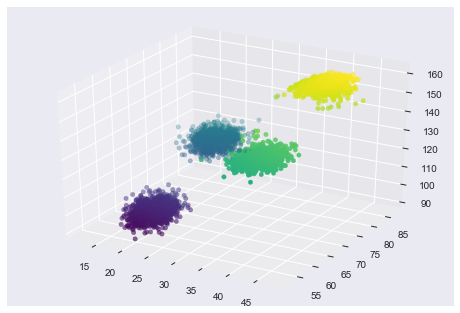

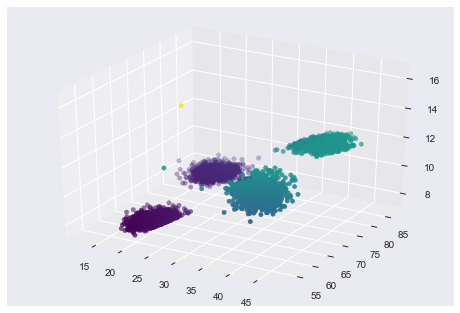

In [13]:
y_mean, y_std = deepensem.predict(X)
plot_data(X, y_mean)
plot_data(X, y_std)

In [14]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_mean, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.44818363170807773
rKL: 0.26549171803796207
JS: 0.0741225062429676
